# Branching ratio calculator
Calculating branching ratios between given states at zero electric and magnetic field. This notebook also requires [`centrex-TlF-couplings`](https://github.com/ograsdijk/CeNTREX-TlF-Hamiltonian)

## Import packages

In [18]:
%load_ext autoreload
%autoreload 2

import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy.random import normal
from tqdm import tqdm

from centrex_TlF_hamiltonian.states import State, CoupledBasisState, UncoupledBasisState, generate_uncoupled_states_ground_mF0, generate_coupled_states_excited_mF0, find_state_idx_from_state, ElectronicState, find_exact_states
from centrex_TlF_hamiltonian.hamiltonian import generate_uncoupled_hamiltonian_X, generate_uncoupled_hamiltonian_X_function, generate_coupled_hamiltonian_B, generate_coupled_hamiltonian_B_function, XConstants, BConstants
from centrex_TlF_hamiltonian.hamiltonian.utils import matrix_to_states
from centrex_TlF_couplings.matrix_elements import generate_ED_ME_mixed_state, ED_ME_coupled

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hamiltonians
### X-state

In [2]:
# Generate quantum numbers
QN_X_uc = generate_uncoupled_states_ground_mF0(range(0,5))

# Generate Hamiltonian
H_X = generate_uncoupled_hamiltonian_X_function(generate_uncoupled_hamiltonian_X(QN_X_uc))(np.array([0,0,0]),np.array([0,0,1e-4]))/(2*np.pi)

#Diagonalize the Hamiltonian and define a new basis where the matrix is diagonal
D, V = np.linalg.eigh(H_X)
H_X_diag = V.conj().T @ H_X @ V

#Remove very small entries from V
V[np.abs(V) < 1e-5] = 0

#New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X_uc)

### B-state

In [3]:
# Generate quantum numbers
QN_B_c = generate_coupled_states_excited_mF0(range(1,6), Ps = [-1,1])

# Generate Hamiltonian
def generate_H_B(B_state_constants = BConstants):
    H_B = generate_coupled_hamiltonian_B_function(generate_coupled_hamiltonian_B(QN_B_c, constants=B_state_constants))
    
    return H_B(np.array([0,0,0]),np.array([0,0,1e-4]))/(2*np.pi)



#Diagonalize the Hamiltonian and define a new basis where the matrix is diagonal
H_B = generate_H_B()
D, V = np.linalg.eigh(H_B)
H_B_diag = V.conj().T @ H_B @ V

#Remove very small entries from V
V[np.abs(V) < 1e-5] = 0

#New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B_c)

## Calculate branching ratios

Define function that calculates matrix elements:

In [4]:
def calculate_BR(excited_state, ground_states, QN_B, H_B, tol = 1e-5):
    """
    Function that calculates branching ratios from the given excited state to the given ground states

    inputs:
    excited_state = state object representing the excited state that is spontaneously decaying
    ground_states = list of state objects that should span all the states to which the excited state can decay

    returns:
    BRs = list of branching ratios to each of the ground states
    """
    ground_states = find_exact_ground_states(ground_states)
    excited_state = find_exact_excited_state(excited_state, QN_B, H_B)
    
    #Initialize container for matrix elements between excited state and ground states
    MEs = np.zeros(len(ground_states), dtype = complex)

    #loop over ground states
    for i, ground_state in enumerate(ground_states):
        MEs[i] = generate_ED_ME_mixed_state(
            ground_state.remove_small_components(tol = tol),
            excited_state.remove_small_components(tol = tol),
            reduced=True
        )
    
    #Calculate branching ratios
    BRs = np.abs(MEs)**2/(np.sum(np.abs(MEs)**2))

    return BRs

def find_exact_ground_states(approx_states):
    """
    Finds the exact states corresponding to approx states
    """
    ground_states=find_exact_states(approx_states, QN_X_diag, H_X_diag)
    return [state.remove_small_components().transform_to_coupled() for state in ground_states]

def find_exact_excited_state(approx_state, QN_B, H_B):
    """
    Finds the exact states corresponding to approx states
    """
    return find_exact_states([approx_state], QN_B, H_B)[0]

### B, J' = 1, F1=3/2, F = 1
This is the excited state used in rotational cooling

In [5]:
ground_states_approx = ([1*CoupledBasisState(F=0, mF=0, J=0, F1=1/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                        +[1*CoupledBasisState(F=1, mF=0, J=0, F1=1/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=2, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=1, mF=0, J=2, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=1, mF=0, J =1, F1=3/2, I1=1/2, I2=1/2, P=-1,Ω=1, electronic_state=ElectronicState.B)

calculate_BR(excited_state_approx, ground_states_approx, QN_B_diag, H_B_diag)

array([0.33675259, 0.14737139, 0.        , 0.38897033, 0.02613648,
       0.10076921])

### B, J' = 2, F1=5/2, F = 3
This is one of the excited states used in detection

In [6]:
ground_states_approx = ([1*CoupledBasisState(F=2, mF=0, J=1, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=4, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=3, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=3, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, P=+1,Ω=1, electronic_state=ElectronicState.B)

calculate_BR(excited_state_approx, ground_states_approx, QN_B_diag, H_B_diag)

array([0.52352355, 0.41542109, 0.01506309, 0.043742  , 0.00225026])

### B, J' = 3, F1=7/2, F = 4
This is one of the excited states used in detection

In [7]:
ground_states_approx = ([1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=5, mF=0, J=4, F1=9/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=4, mF=0, J=4, F1=9/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=4, mF=0, J=4, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=4, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=4, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, P=-1,Ω=1, electronic_state=ElectronicState.B)

calculate_BR(excited_state_approx, ground_states_approx, QN_B_diag, H_B_diag)

array([0.5301435 , 0.43590422, 0.00938837, 0.02386614, 0.00069776])

## Calculating branching ratios with errorbars

In [8]:
def calculate_BR_with_errors(excited_state, ground_states, tol = 1e-5, Ntrials = 10):
    """
    Function that calculates branching ratios from the given excited state to the given ground states

    inputs:
    excited_state = state object representing the excited state that is spontaneously decaying
    ground_states = list of state objects that should span all the states to which the excited state can decay

    returns:
    BRs = list of branching ratios to each of the ground states
    """
    #Define arrays of parameters
    Brot = normal(6687.879e6,0.0026e6, size = Ntrials)
    Drot = normal(0.010869e6,0.000027e6, size = Ntrials)
    H_const = normal(-8.1,0.6, size = Ntrials)*1e-2
    h1_Tl = normal(28789e6,42e6, size = Ntrials)
    h1_F = normal(861e6,20e6, size = Ntrials)
    q = normal(2.423e6,0, size = Ntrials)
    c_Tl = normal(-7.83e6,1.57e6, size = Ntrials)
    c1p_Tl = normal(11.17e6,3e6, size = Ntrials)
    
    # Array for results
    BRs = np.empty((len(ground_states), Ntrials), dtype = float)
    
    B_constants = copy.deepcopy(BConstants())

    
    for n in tqdm(range(Ntrials)):
        # Generate Hamiltonian with new constants
        B_constants.B_rot = Brot[n]
        B_constants.D_rot = Drot[n]
        B_constants.H_const = H_const[n]
        B_constants.h1_Tl = h1_Tl[n]
        B_constants.h1_F = h1_F[n]
        B_constants.q = q[n]
        B_constants.c_Tl = c_Tl[n]
        B_constants.c1p_Tl = c1p_Tl[n]
        # display(B_constants)
        H_B = generate_H_B(B_state_constants=B_constants)


        #Diagonalize the Hamiltonian and define a new basis where the matrix is diagonal
        D, V = np.linalg.eigh(H_B)
        H_B_diag = V.conj().T @ H_B @ V
        
        #Remove very small entries from V
        V[np.abs(V) < 1e-5] = 0

        #New set of quantum numbers:
        QN_B_diag = matrix_to_states(V, QN_B_c)
                
        BRs[:,n] = np.array(calculate_BR(excited_state, ground_states, QN_B_diag, H_B_diag))
    
    return BRs

### B, J' = 1, F1=3/2, F = 1
This is the excited state used in rotational cooling

In [16]:
ground_states_approx = ([1*CoupledBasisState(F=0, mF=0, J=0, F1=1/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                        +[1*CoupledBasisState(F=1, mF=0, J=0, F1=1/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=2, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=1, mF=0, J=2, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=1, mF=0, J =1, F1=3/2, I1=1/2, I2=1/2, P=-1,Ω=1, electronic_state=ElectronicState.B)

BRs = calculate_BR_with_errors(excited_state_approx, ground_states_approx, Ntrials=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:54<00:00,  1.40it/s]


Text(0.5, 1.0, 'Branching ratio to F = 1')

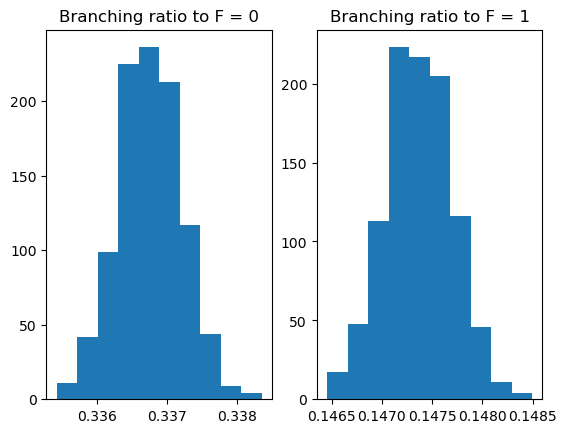

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].hist(BRs[0,:])
ax[0].set_title("Branching ratio to F = 0")
ax[1].hist(BRs[1,:])
ax[1].set_title("Branching ratio to F = 1")

In [26]:
BR_F0 = np.mean(BRs[0,:])
BR_F0_uc = np.std(BRs[0,:])
print(f"Branching ratio to J=0, F = 0: {BR_F0:.4f}+/-{BR_F0_uc:.4f}")

BR_F1 = np.mean(BRs[1,:])
BR_F1_uc = np.std(BRs[1,:])
print(f"Branching ratio to J=0, F = 1: {BR_F1:.4f}+/-{BR_F1_uc:.4f}")

Branching ratio to J=0, F = 0: 0.3367+/-0.0005
Branching ratio to J=0, F = 1: 0.1474+/-0.0003


### B, J' = 2, F1=5/2, F = 3
This is one of the excited states used in detection

In [27]:
ground_states_approx = ([1*CoupledBasisState(F=2, mF=0, J=1, F1=3/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=4, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=3, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=2, mF=0, J=3, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=-1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, P=+1,Ω=1, electronic_state=ElectronicState.B)

BRs = calculate_BR_with_errors(excited_state_approx, ground_states_approx, Ntrials=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:51<00:00,  1.05it/s]


Text(0.5, 1.0, 'Branching ratio to J = 3')

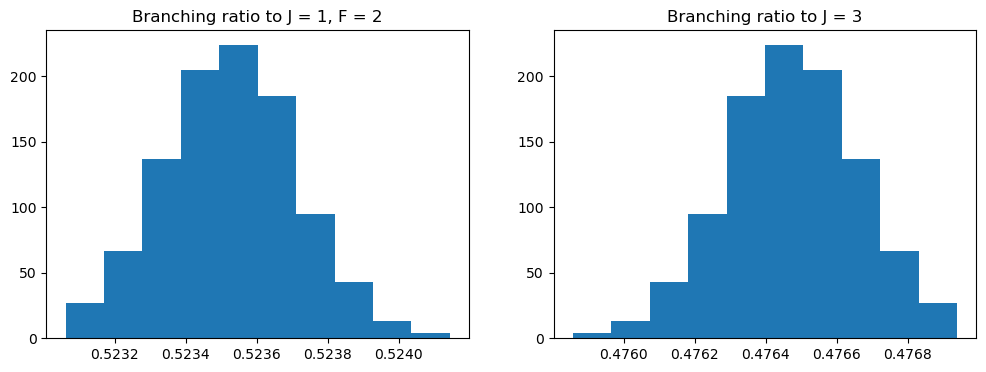

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].hist(BRs[0,:])
ax[0].set_title("Branching ratio to J = 1, F = 2")
ax[1].hist(np.sum(BRs[1:,:], axis = 0))
ax[1].set_title("Branching ratio to J = 3")

### B, J' = 3, F1=7/2, F = 4
This is one of the excited states used in detection

In [33]:
ground_states_approx = ([1*CoupledBasisState(F=3, mF=0, J=2, F1=5/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)]
                       +[1*CoupledBasisState(F=5, mF=0, J=4, F1=9/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=4, mF=0, J=4, F1=9/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=4, mF=0, J=4, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X),
                         1*CoupledBasisState(F=3, mF=0, J=4, F1=7/2, I1=1/2, I2=1/2, Ω=0, P=+1, electronic_state=ElectronicState.X)])

excited_state_approx = 1*CoupledBasisState(F=4, mF=0, J=3, F1=7/2, I1=1/2, I2=1/2, P=-1,Ω=1, electronic_state=ElectronicState.B)

BRs = calculate_BR_with_errors(excited_state_approx, ground_states_approx, Ntrials = 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:34<00:00,  1.23s/it]


Text(0.5, 1.0, 'Branching ratio to J = 4')

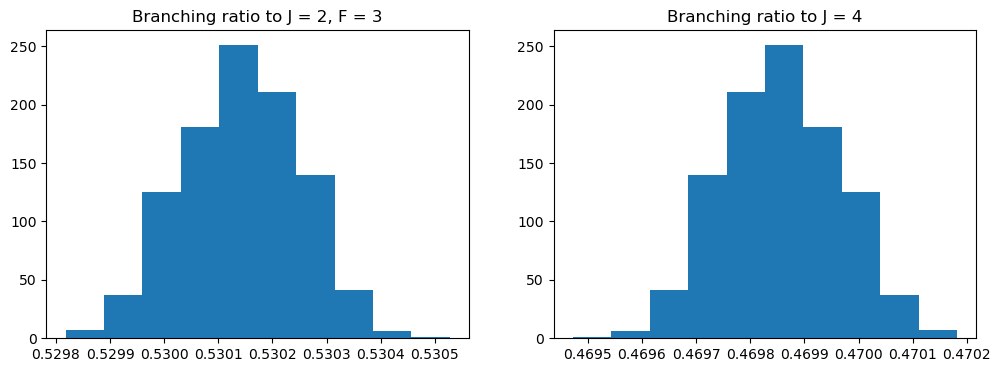

In [34]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].hist(BRs[0,:])
ax[0].set_title("Branching ratio to J = 2, F = 3")
ax[1].hist(np.sum(BRs[1:,:], axis = 0))
ax[1].set_title("Branching ratio to J = 4")